# Deep Convolutional Generative Adversarial Network

In [12]:
import tensorflow as tf

In [13]:
tf.__version__

'2.8.0'

In [15]:
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import time

### Load and prepare the dataset

In [16]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [21]:
import pandas as pd
d = {
    'id': range(1,BUFFER_SIZE+1),
    'image': ["sample.png"]*BUFFER_SIZE,
    'eyes': ["normal"]*BUFFER_SIZE,
    'nose': ["normal"]*BUFFER_SIZE,
    'hair': ["normal"]*BUFFER_SIZE,
}
df = pd.DataFrame(data=d)

In [51]:
df.iloc[[0]]

,id,image,eyes,nose,hair
0,1,sample.png,normal,normal,normal


In [23]:
train_dataset = []

for idx, row in df.iterrows():
    im = imageio.imread(row['image'])
    im = im.reshape(28, 28, 1).astype('float32')
    im = (im - 127.5) / 127.5  # Normalize the images to [-1, 1]

    eyes = row["eyes"]
    nose = row["nose"]
    hair = row["hair"]
    train_dataset.append([eyes, nose, hair, im])

C:\Users\Tom\AppData\Local\Temp\ipykernel_20988\2555076114.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(row['image'])


## Create the models


### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [24]:
features = [("eyes", 3), ("nose", 5), ("hair", 4)]
def build_feature_columns(features: dict):
    feature_layer_inputs = {}
    feature_columns = []
    for name, hash_bucket_size in features:
        feature_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_hash_bucket(name, hash_bucket_size=hash_bucket_size)))
        feature_layer_inputs[name] = layers.Input(shape=(), name=name, dtype=tf.string)
    return feature_columns, feature_layer_inputs

In [25]:
def make_generator_model():
    feature_columns, feature_layer_inputs = build_feature_columns(features=features)
    fc_layer = layers.DenseFeatures(feature_columns)
    fc = fc_layer(feature_layer_inputs)

    image_input = layers.Input(shape=(100,), name='noise')

    x = layers.concatenate([fc, image_input], axis=1)
    x = layers.Dense(7*7*256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    inputs = list(feature_layer_inputs.values())
    inputs.append(image_input)
    model = Model(inputs=inputs, outputs=x, name="generator")
    return model

Use the (as yet untrained) generator to create an image.

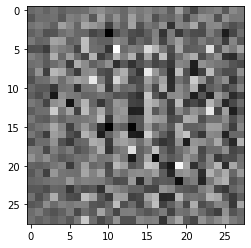

In [52]:
generator = make_generator_model()
# generator.summary()

noise = tf.random.normal([1, 100])
eyes = tf.constant([train_dataset[0][0]])
nose = tf.constant([train_dataset[0][1]])
hair = tf.constant([train_dataset[0][2]])
generated_image = generator([eyes, nose, hair, noise], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [27]:
# Batch Size == 2

# generator = make_generator_model()
# generator.summary()
#
# noise = tf.random.normal([2, 100])
# foo = tf.constant(["normal","normal"])
# generated_image = generator([foo, foo, foo, noise], training=False)
# print(f"foo shape: {foo.shape}")
#
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [28]:
def make_discriminator_model():

    image_input = layers.Input(shape=(28, 28, 1), name='image')

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)

    feature_columns, feature_layer_inputs = build_feature_columns(features=features)
    fc_layer = layers.DenseFeatures(feature_columns)
    fc = fc_layer(feature_layer_inputs)

    x = layers.concatenate([fc, x], axis=1)

    x = layers.Dense(1)(x)

    inputs = list(feature_layer_inputs.values())
    inputs.append(image_input)
    model = Model(inputs=inputs, outputs=x, name="descriminator")

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [29]:
discriminator = make_discriminator_model()
decision = discriminator([eyes, nose, hair, generated_image])
print (decision)

tf.Tensor([[-0.03264582]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [30]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [32]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [63]:
os.makedirs('output', exist_ok = True)

checkpoint_dir = './output/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [35]:
EPOCHS = 3
noise_dim = 100
num_examples_to_generate = 16

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [36]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(eyes, nose, hair, images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # print(f"eyes shape: {eyes.shape}")
    # print(f"nose shape: {nose.shape}")
    # print(f"hair shape: {hair.shape}")
    # print(f"images shape: {images.shape}")

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([eyes, nose, hair, noise], training=True)

      real_output = discriminator([eyes, nose, hair, images], training=True)
      fake_output = discriminator([eyes, nose, hair, generated_images], training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [37]:
import random

In [47]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    random.shuffle(dataset)
    batch = dataset[:BATCH_SIZE]

    eyes = []
    nose = []
    hair = []
    images = []
    for item in batch:
        eyes.append(item[0])
        nose.append(item[1])
        hair.append(item[2])
        images.append(item[3])

    eyes = tf.convert_to_tensor(eyes)
    nose = tf.convert_to_tensor(nose)
    hair = tf.convert_to_tensor(hair)
    images = tf.convert_to_tensor(images)

    train_step(eyes, nose, hair, images)

    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator, epochs)

**Generate and save images**


In [61]:
def generate_and_save_images(model, epoch):
  test_input = [eyes, nose, hair, noise]
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('output/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

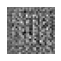

Time for epoch 1 is 0.24991989135742188 sec


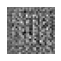

Time for epoch 2 is 0.2554302215576172 sec


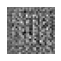

Time for epoch 3 is 0.27091312408447266 sec


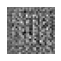

In [64]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [50]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [65]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('output/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(1)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'output/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('output/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)